In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re
import cosinorage as csa

In [37]:
# Load wear periods
wear_df = pd.read_csv("wear_periods.csv")
# Clean up column names (remove leading/trailing spaces)
wear_df.columns = [c.strip() for c in wear_df.columns]

# Also strip whitespace from all string cells in the dataframe
wear_df = wear_df.map(lambda x: x.strip() if isinstance(x, str) else x)

# Get all CSV files in the minute_level directory and sort them lexicographically by filename
csv_files = sorted(glob.glob("minute_level/*.csv"))

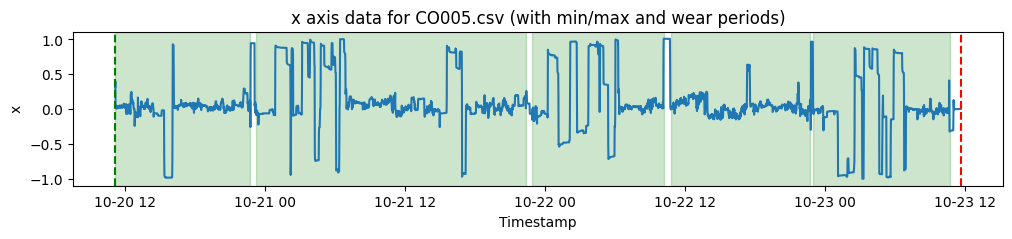

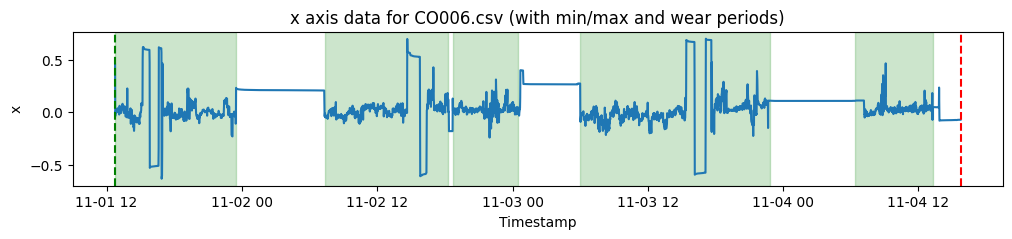

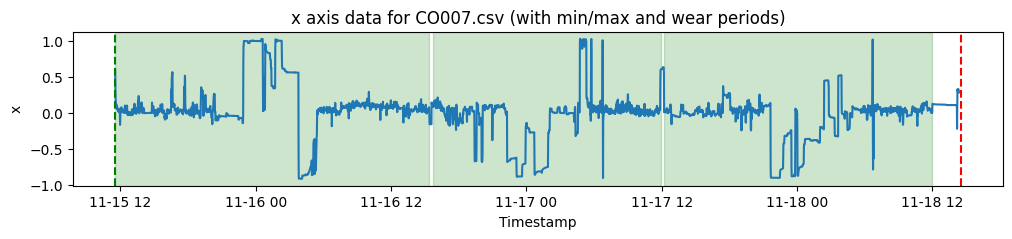

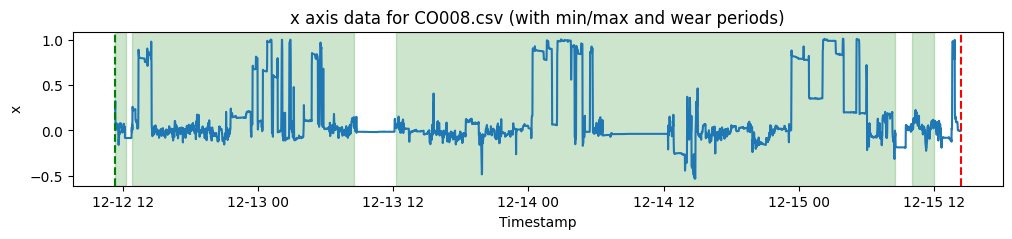

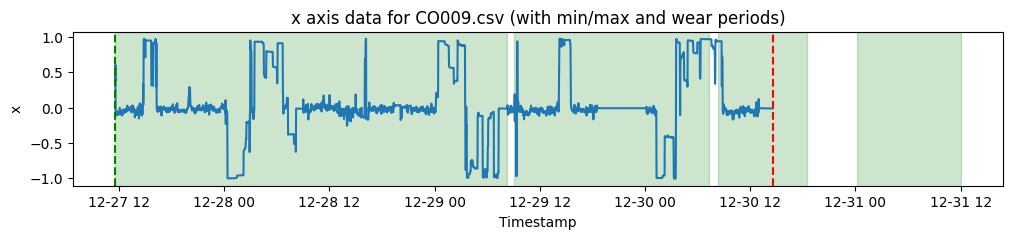

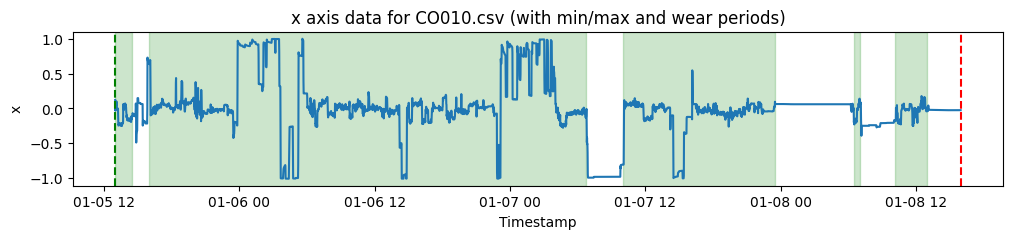

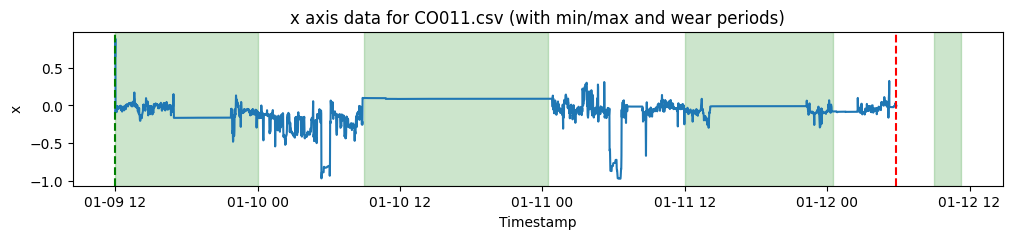

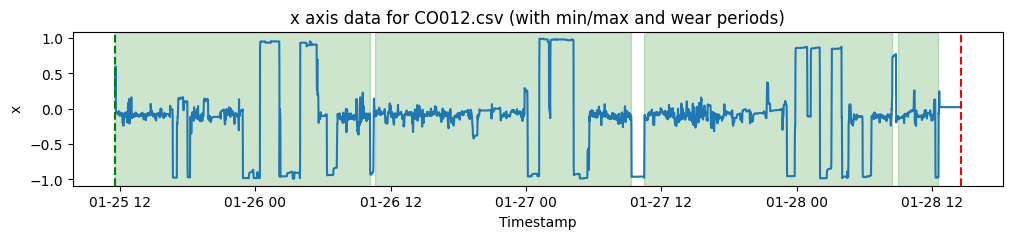

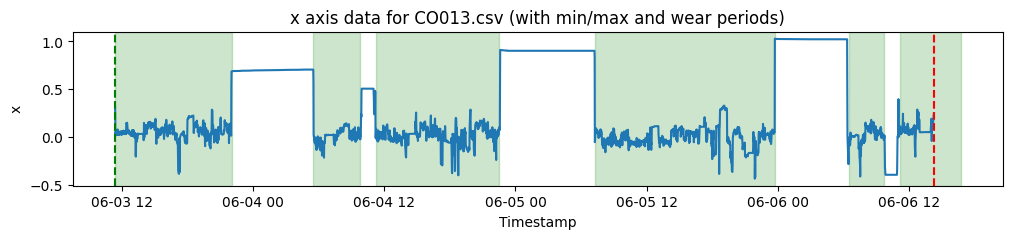

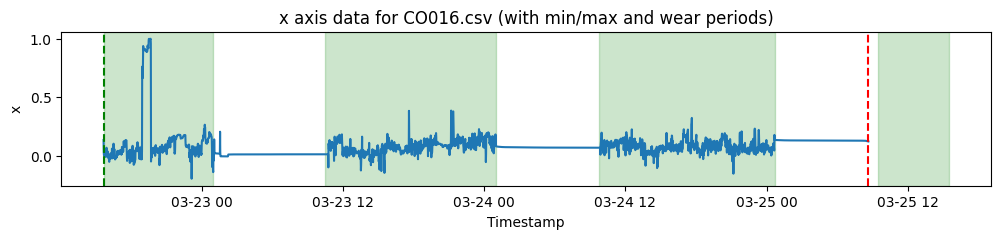

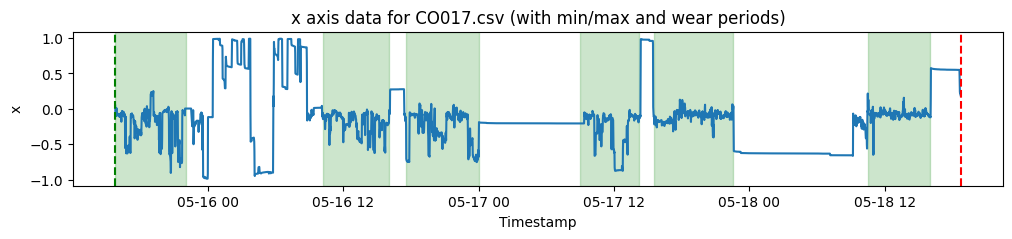

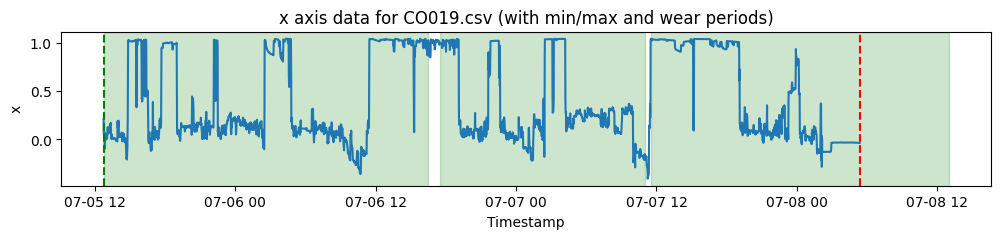

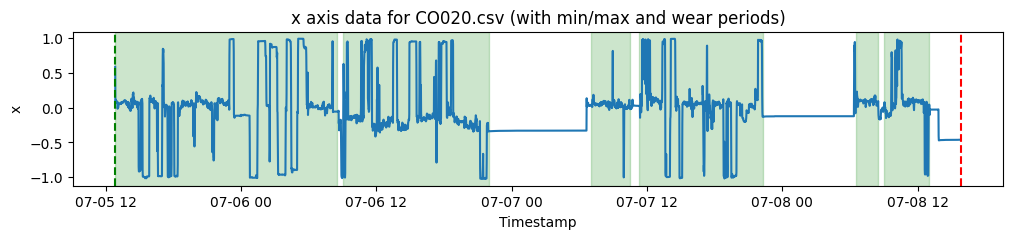

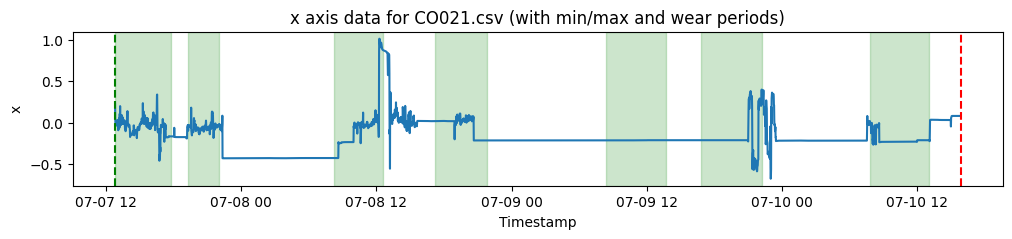

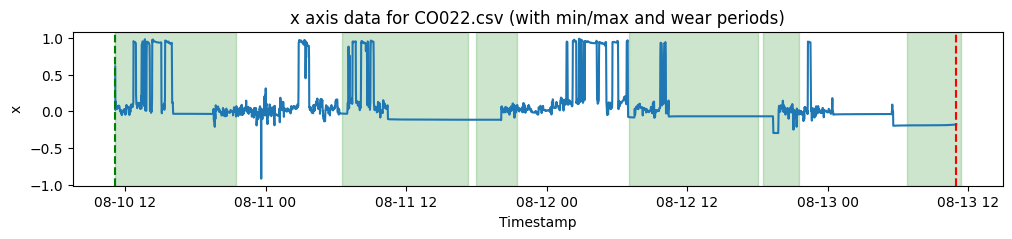

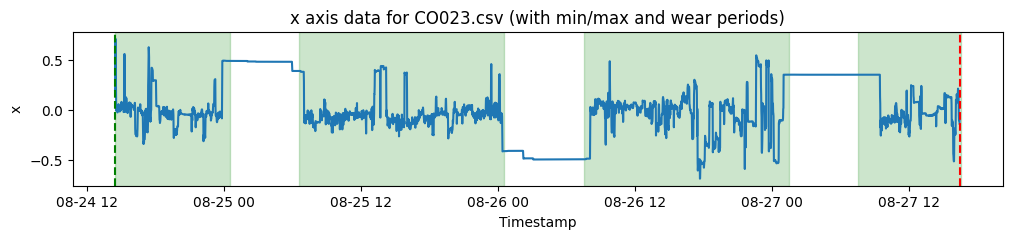

No file found for pig_id CO-026


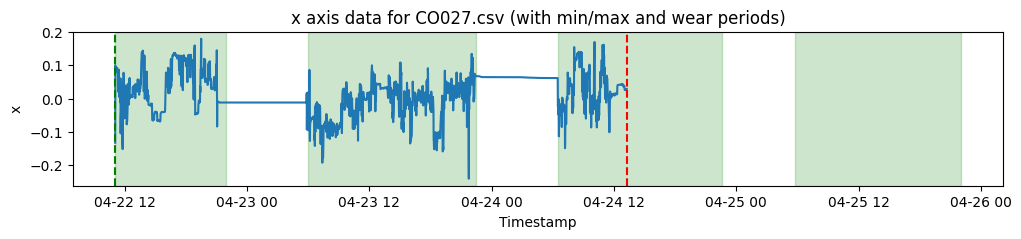

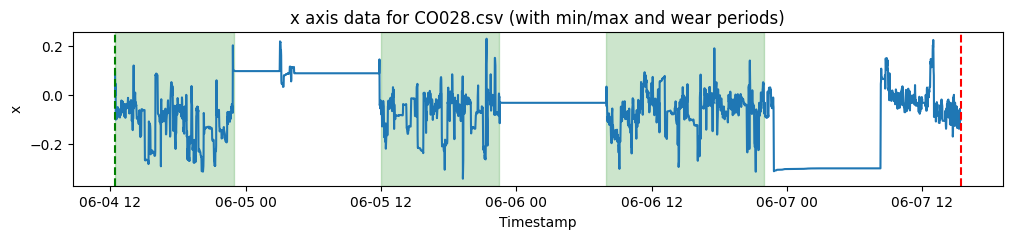

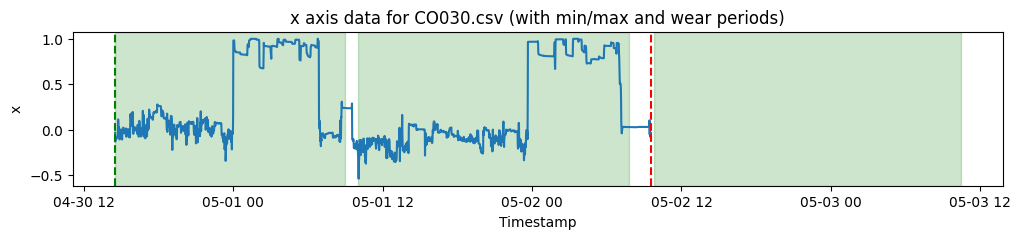

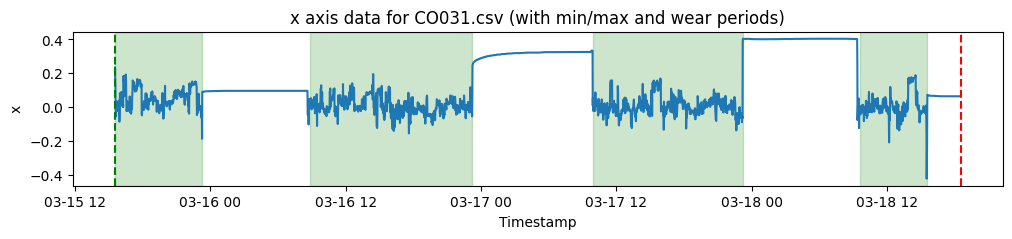

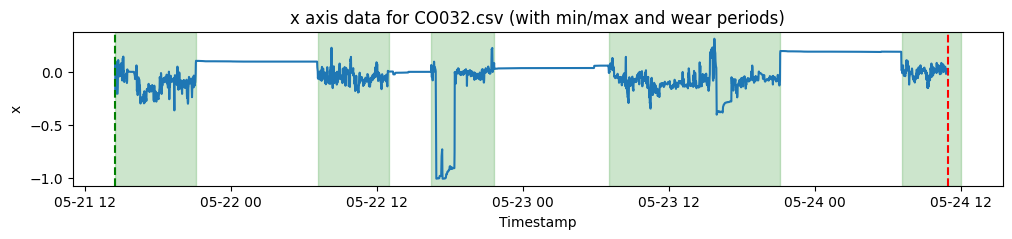

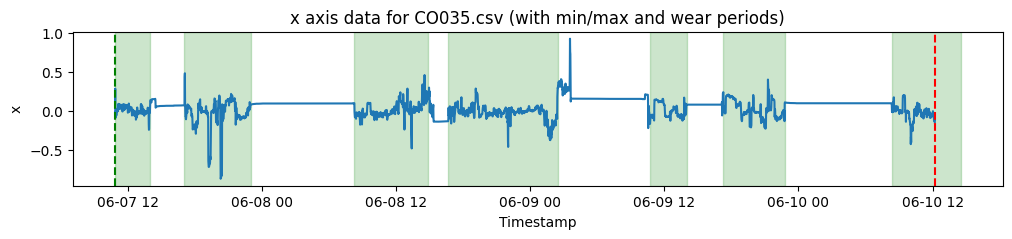

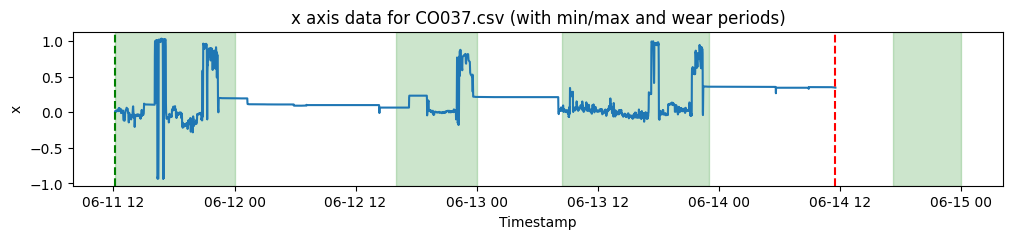

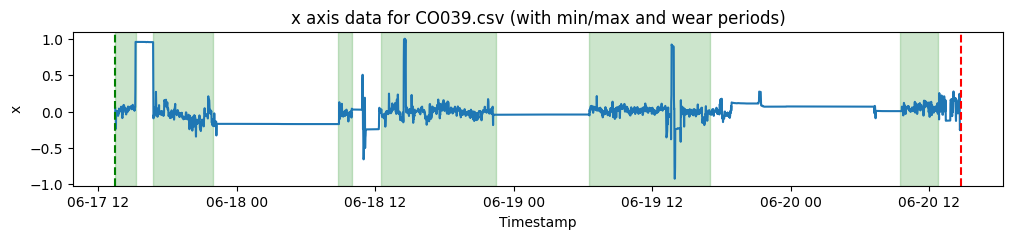

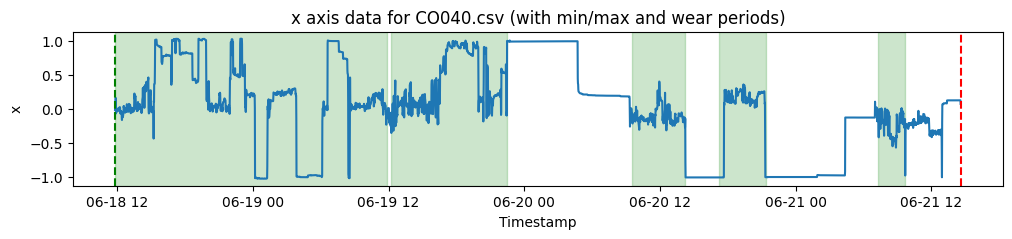

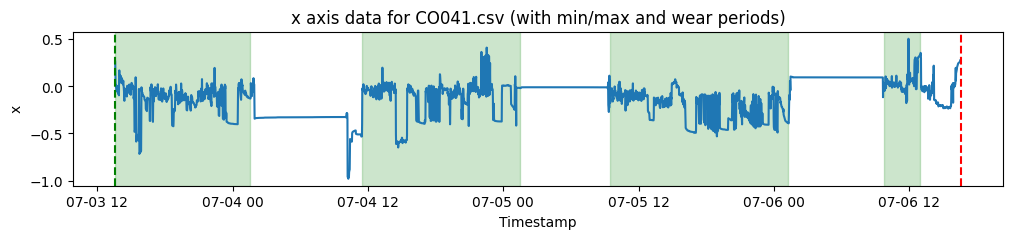

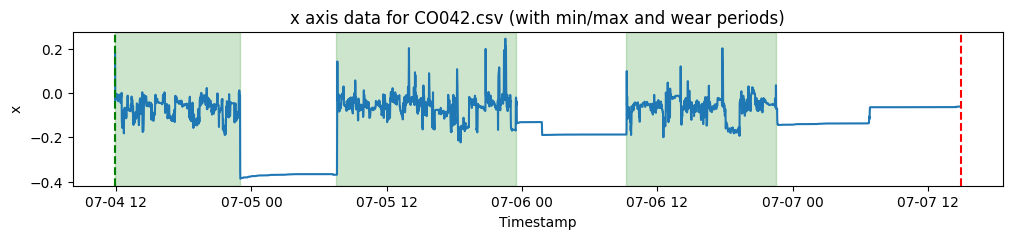

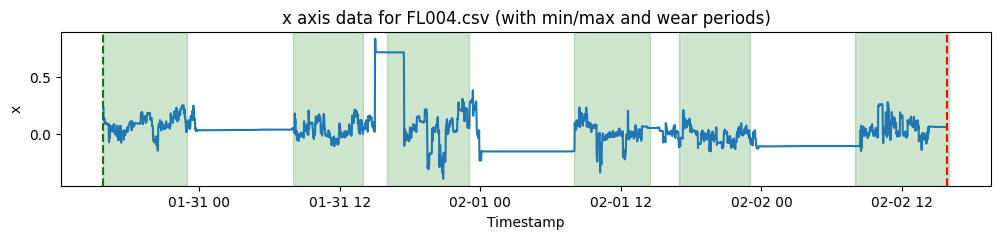

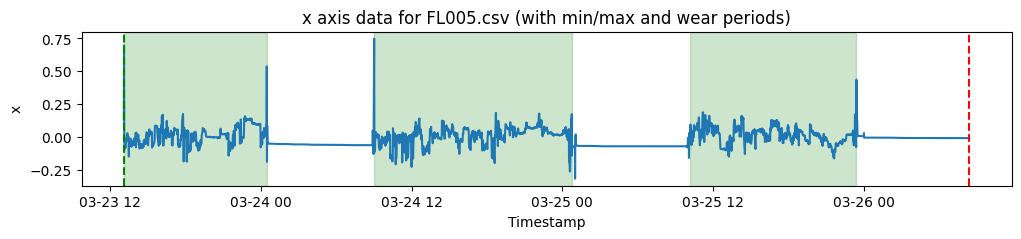

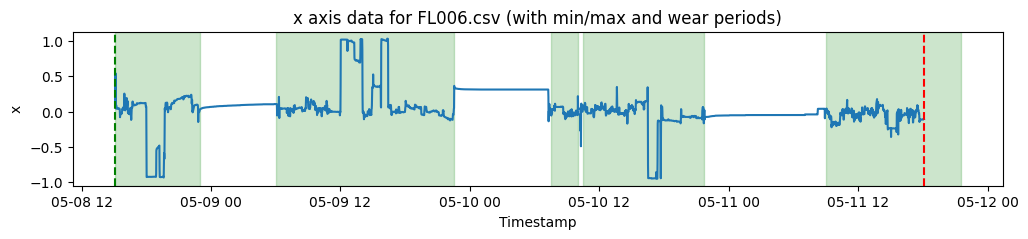

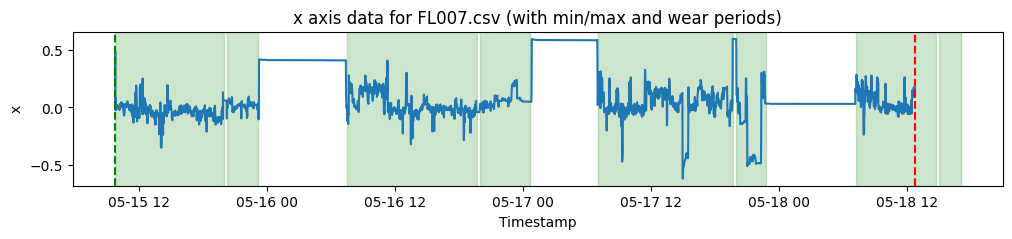

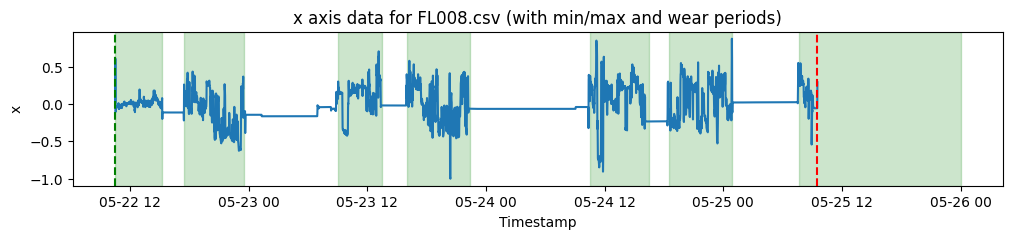

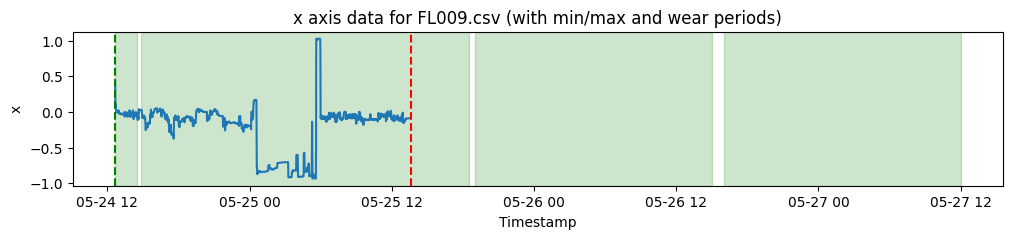

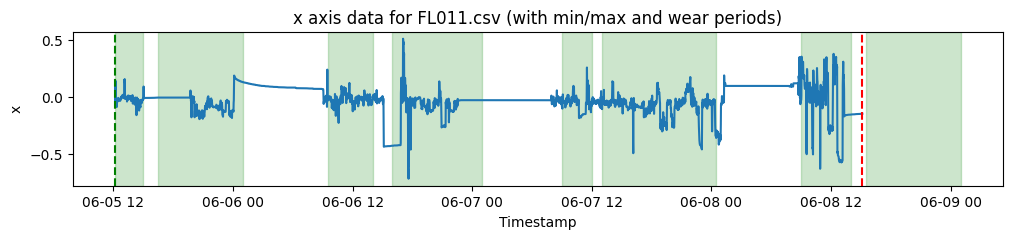

No file found for pig_id FL-013


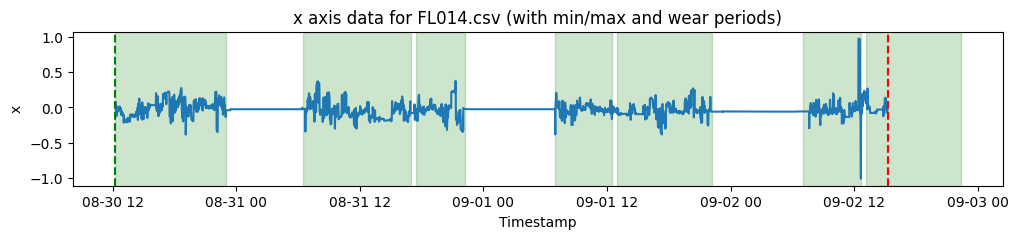

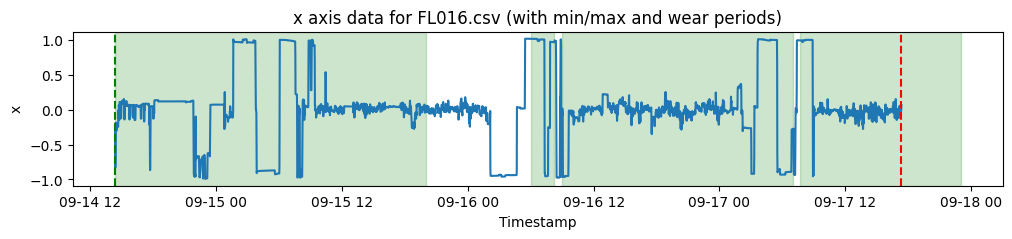

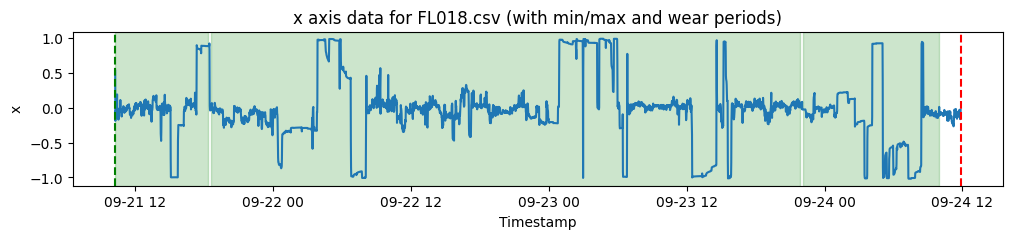

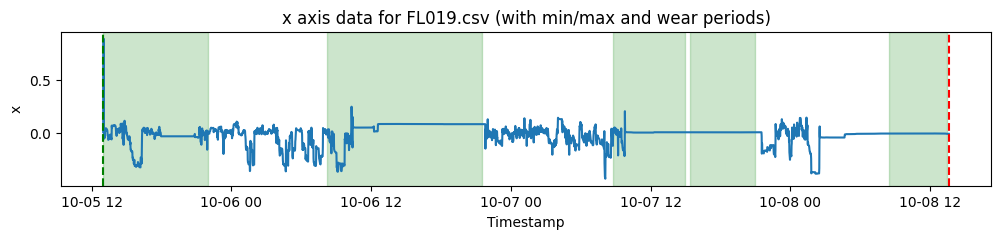

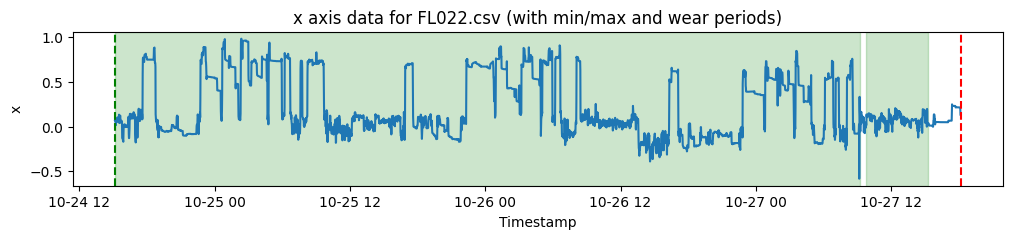

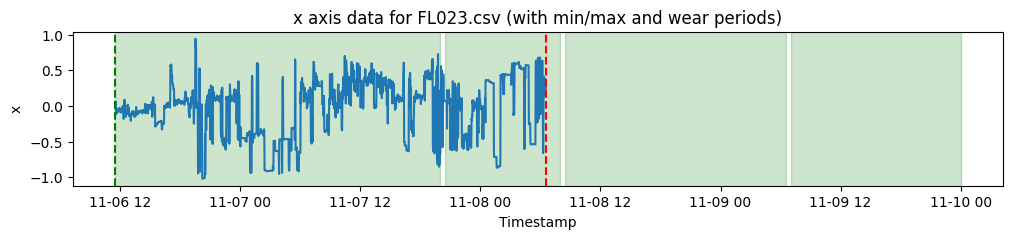

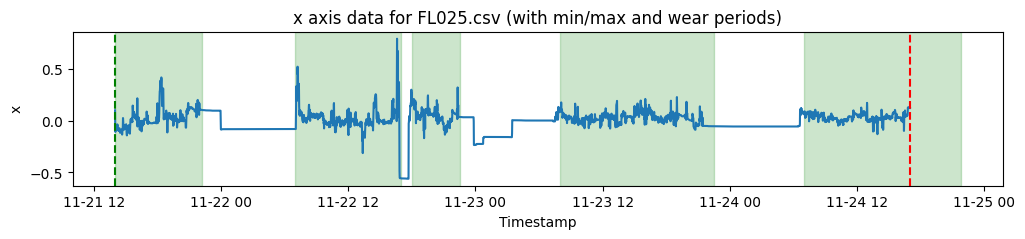

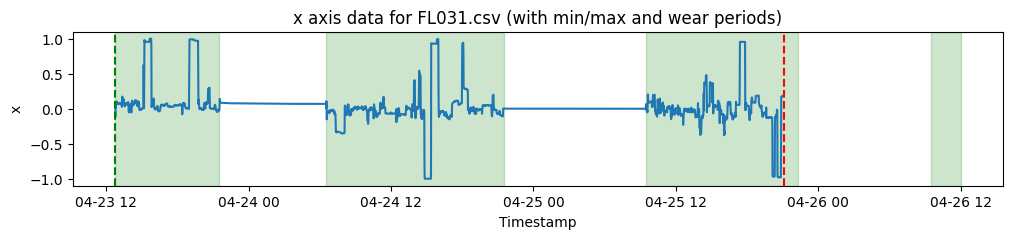

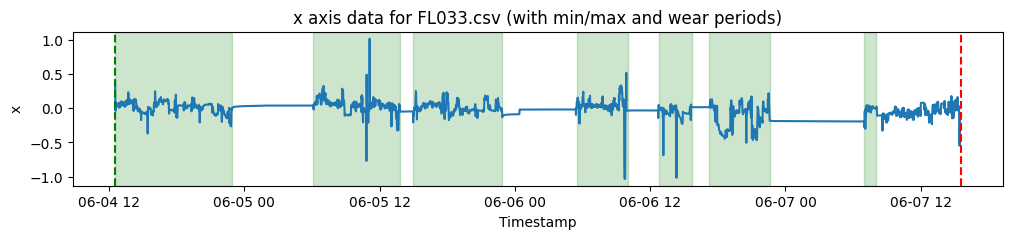

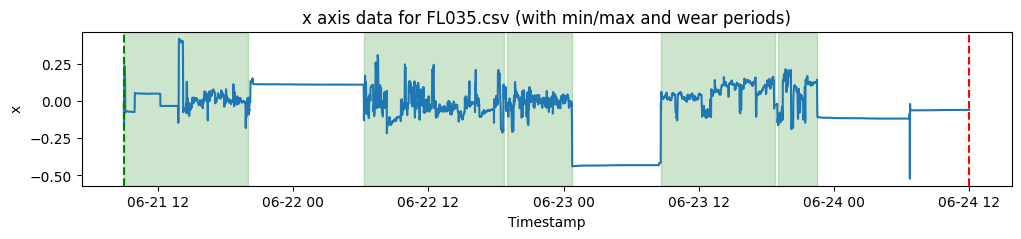

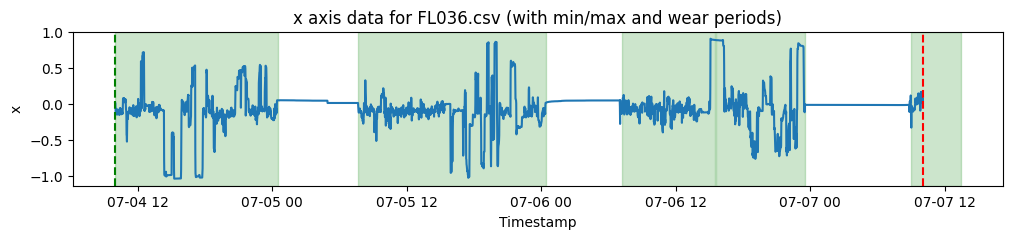

In [38]:
# For each pig_id in wear_df, try to find and plot the corresponding timeseries
for idx, row in wear_df.iterrows():
    pig_id = row['pig_id']
    # Accept both CO-001.csv and CO_001.csv, case-insensitive
    pig_id_pattern = pig_id.replace("-", "[-_]?")
    pattern = re.compile(rf"{pig_id_pattern}\.csv$", re.IGNORECASE)
    matching_files = [f for f in csv_files if pattern.search(os.path.basename(f))]
    if not matching_files:
        print(f"No file found for pig_id {pig_id}")
        continue
    csv_file = matching_files[0]
    df = pd.read_csv(csv_file)
    ts = pd.to_datetime(df['timestamp'])
    file_label = os.path.basename(csv_file)

    plt.figure(figsize=(12, 2))
    plt.plot(ts, df['x'], label=f"{file_label} x")
    plt.axvline(ts.min(), color='g', linestyle='--', label='Min timestamp')
    plt.axvline(ts.max(), color='r', linestyle='--', label='Max timestamp')

    # Plot wear periods as green bands
    for i in range(1, 11):
        start_col = f'wear_start_{i}'
        end_col = f'wear_end_{i}'
        start = row[start_col] if pd.notna(row[start_col]) else ''
        end = row[end_col] if pd.notna(row[end_col]) else ''
        if start and end:
            start_dt = pd.to_datetime(start)
            end_dt = pd.to_datetime(end)
            plt.axvspan(start_dt, end_dt, color='green', alpha=0.2)

    plt.xlabel('Timestamp')
    plt.ylabel('x')
    plt.title(f'x axis data for {file_label} (with min/max and wear periods)')
    plt.show()

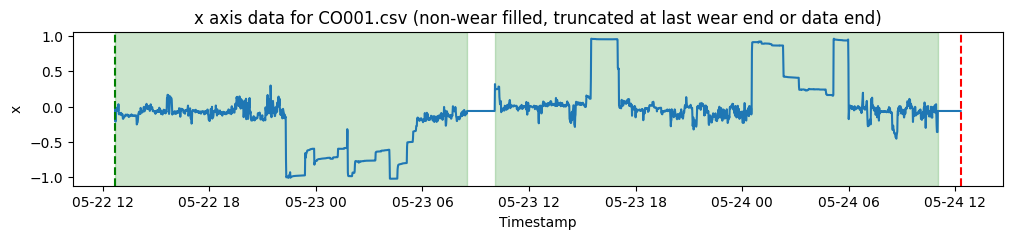

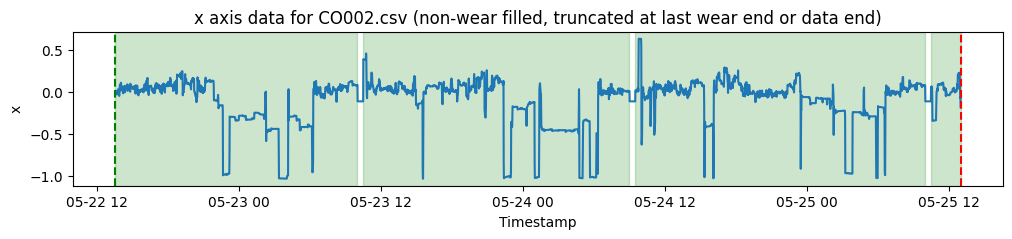

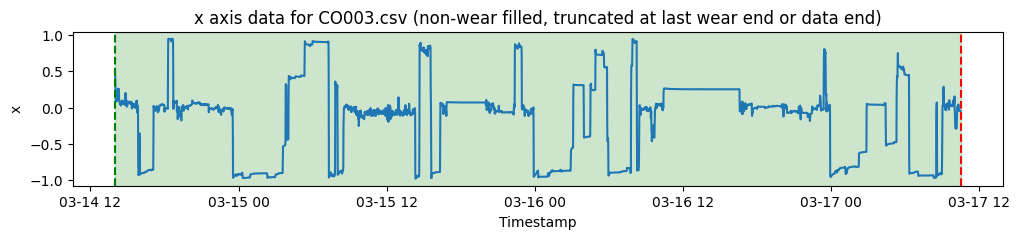

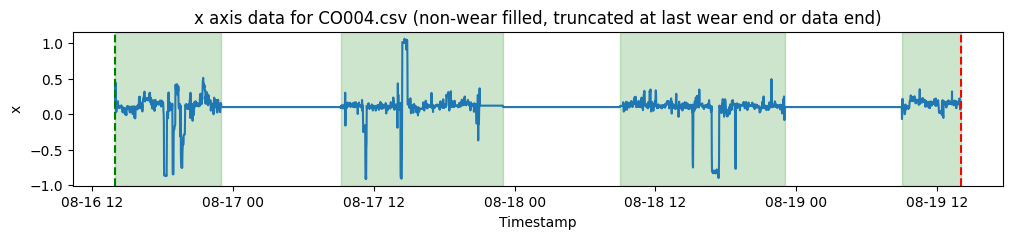

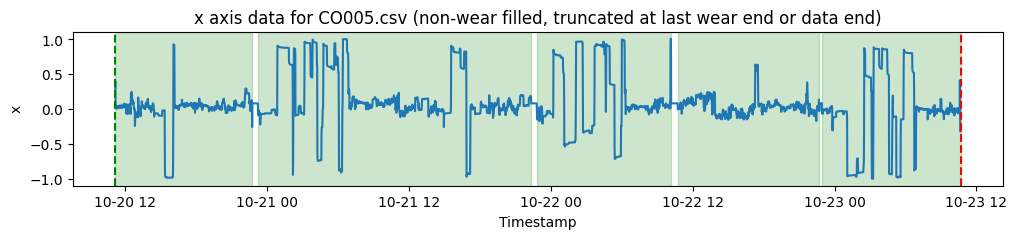

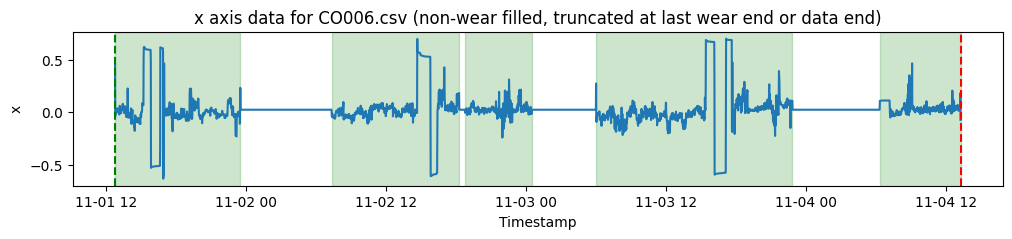

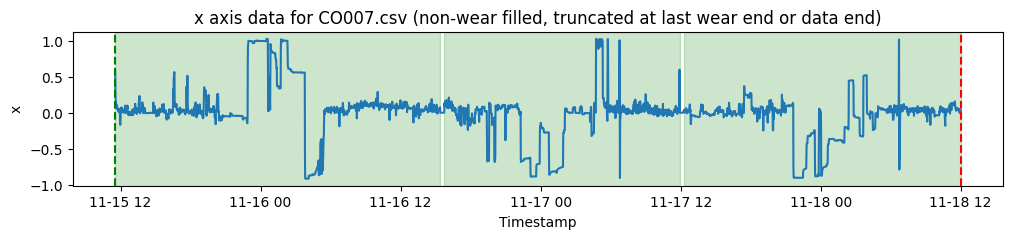

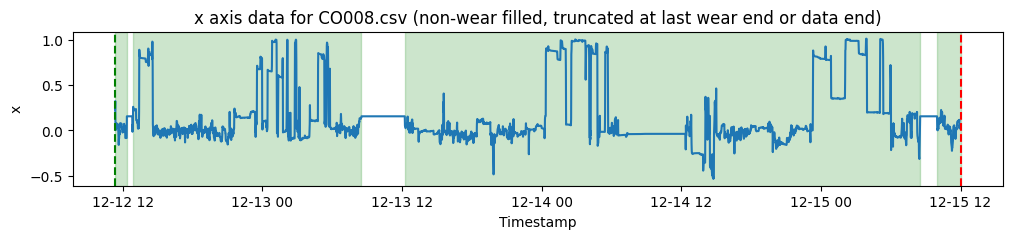

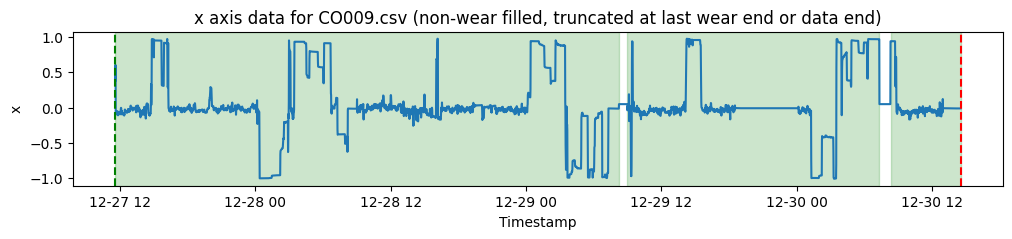

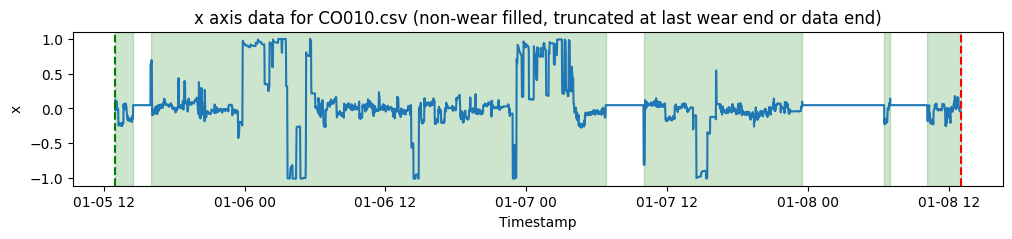

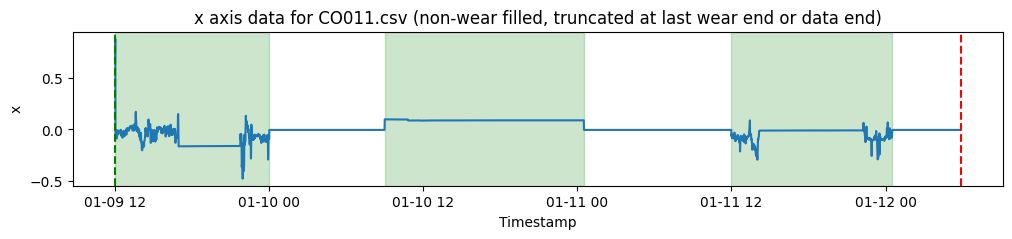

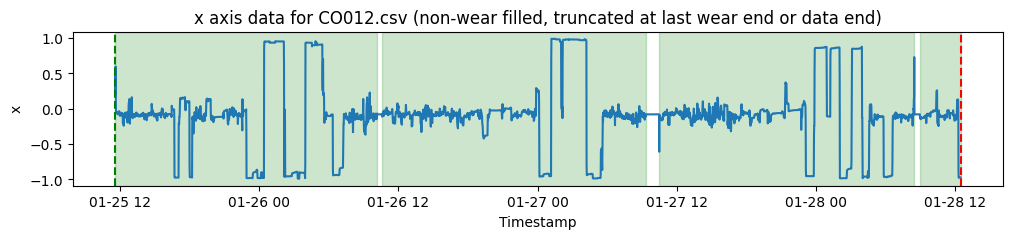

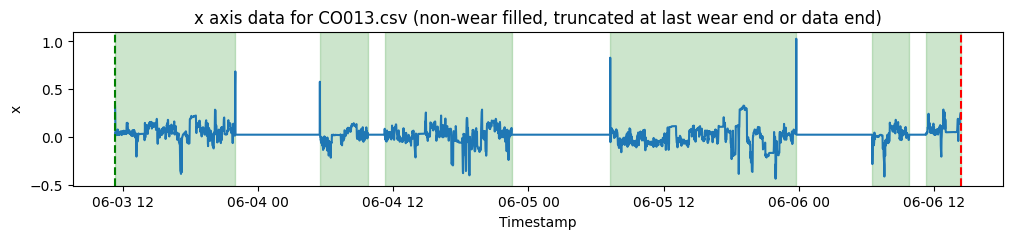

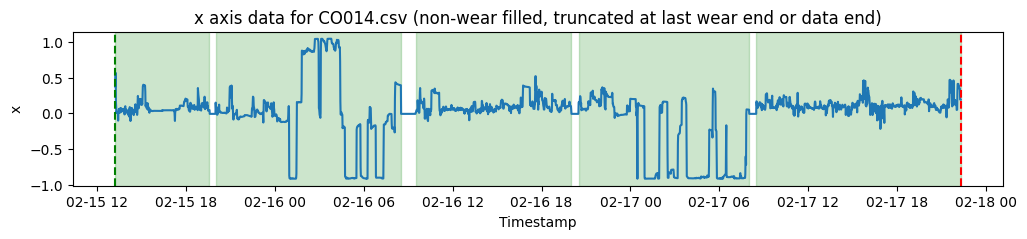

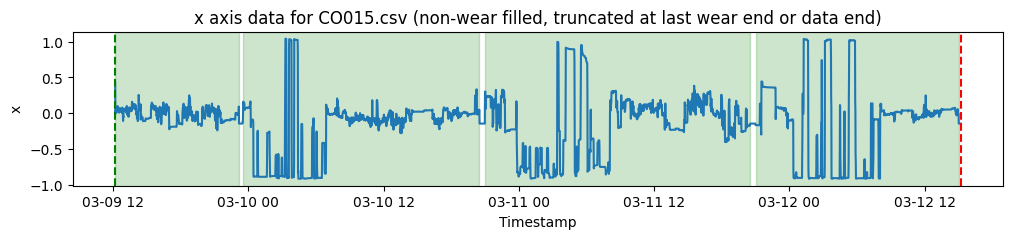

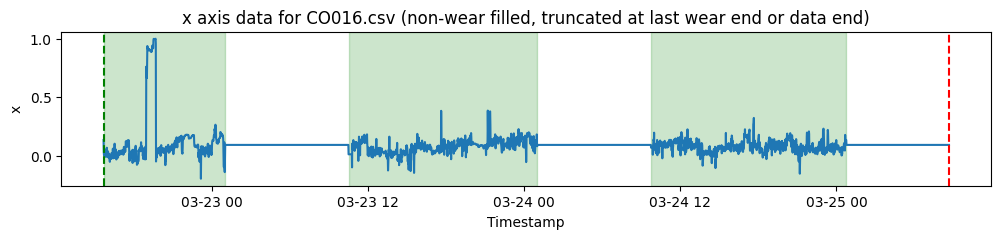

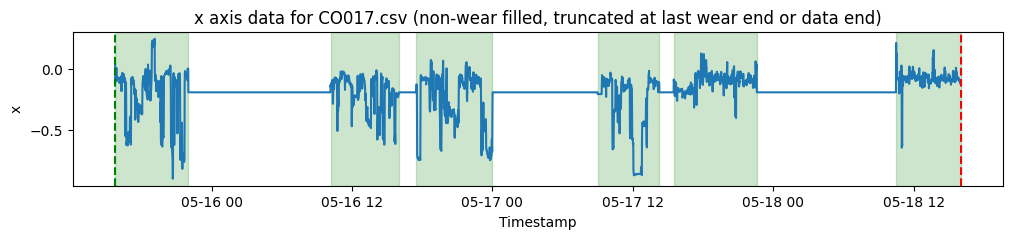

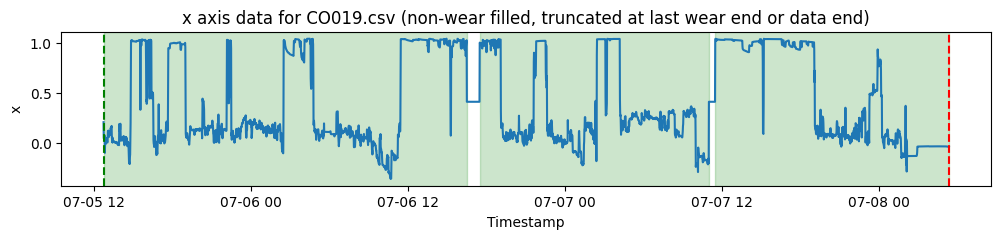

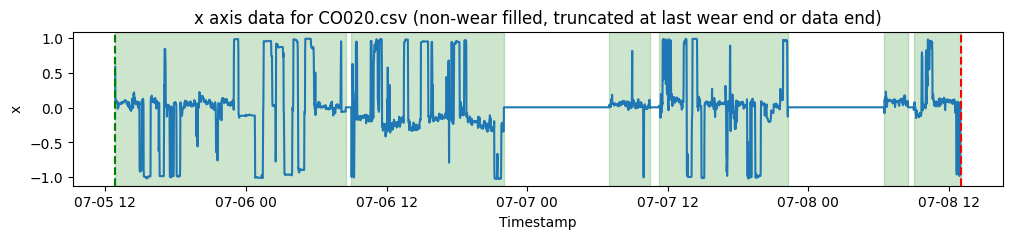

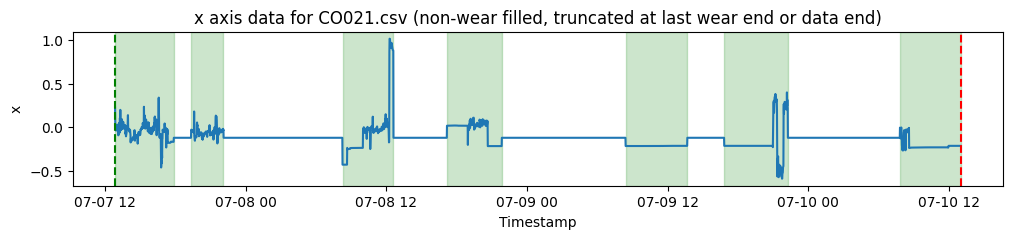

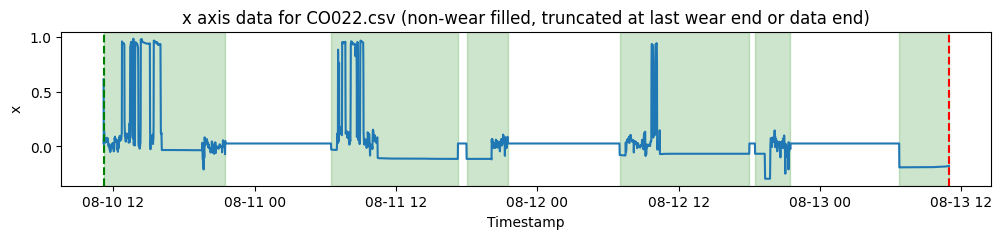

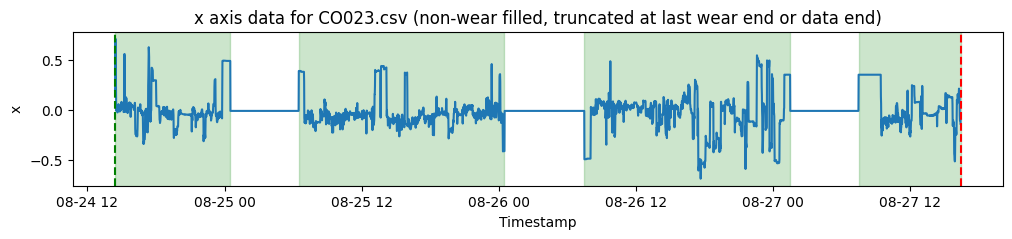

No file found for pig_id CO-026


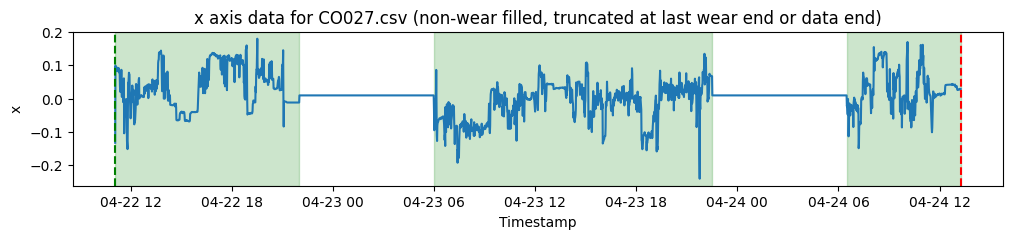

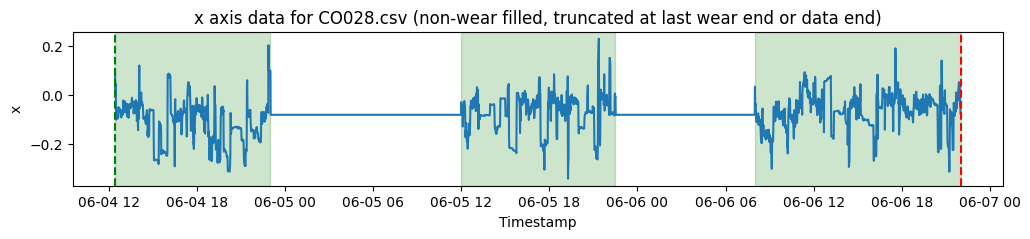

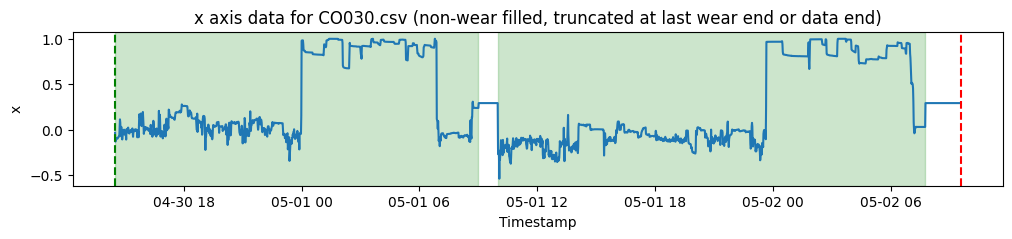

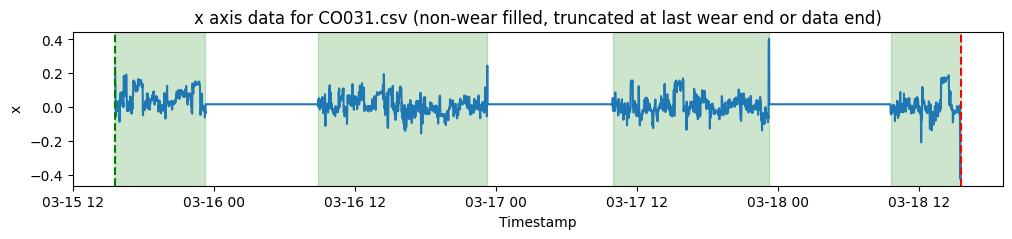

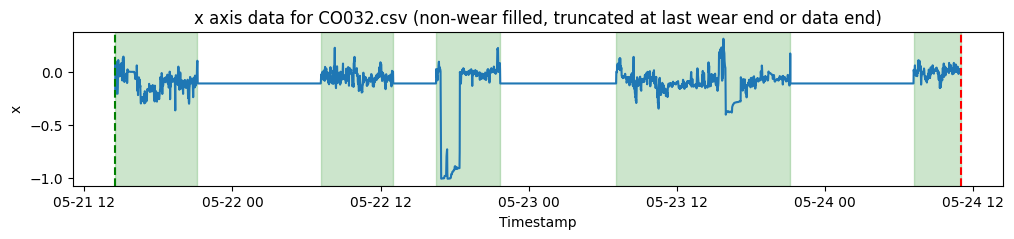

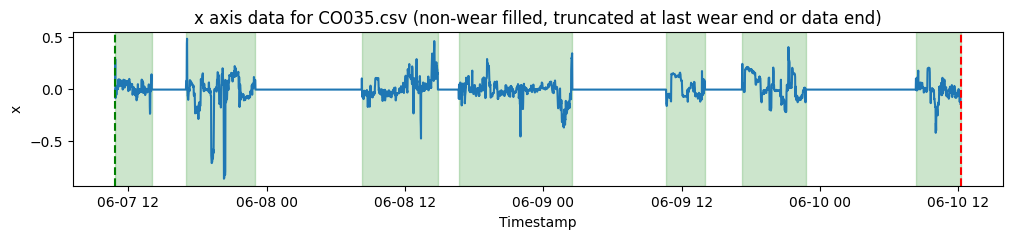

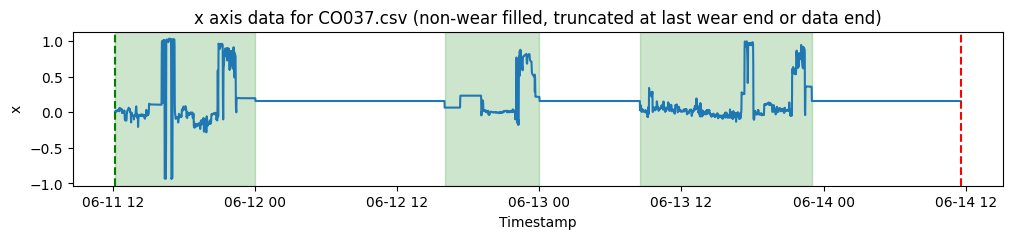

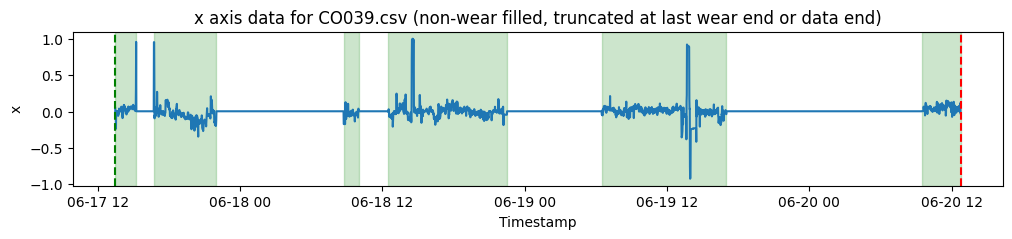

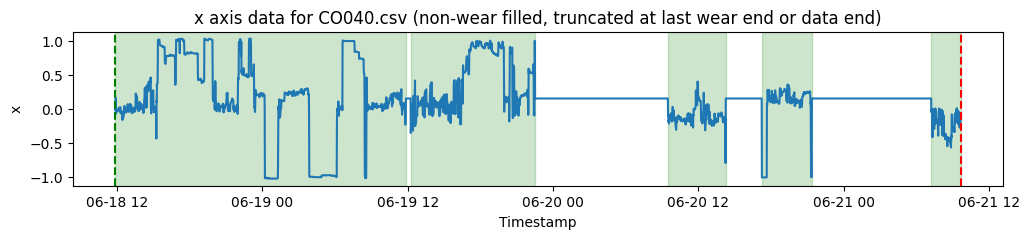

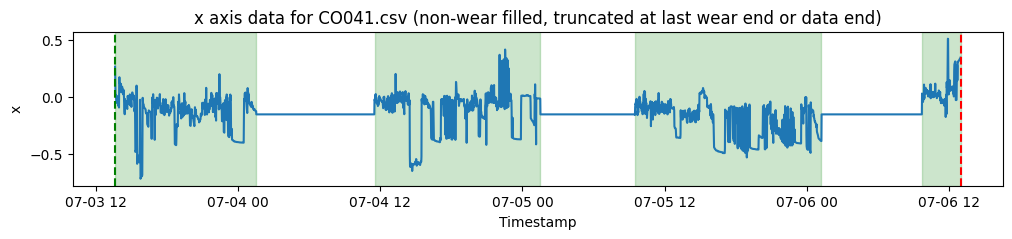

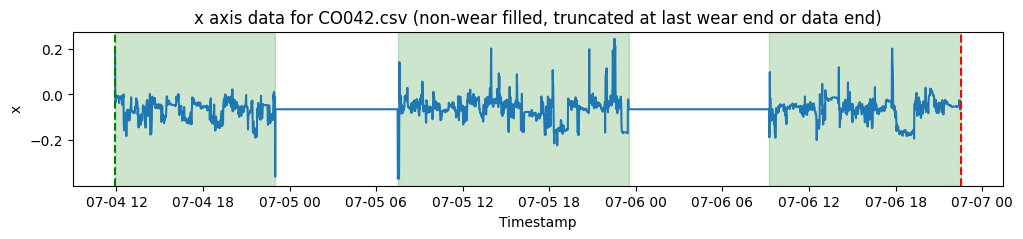

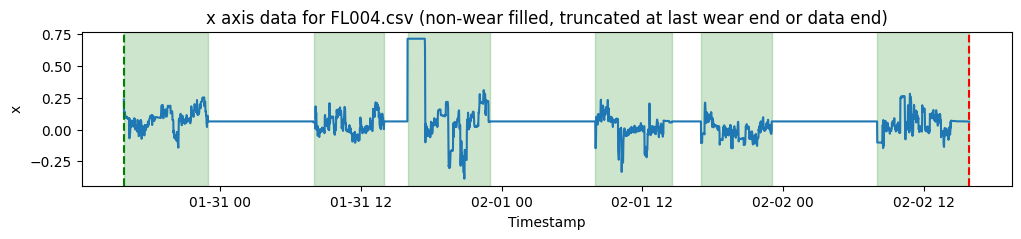

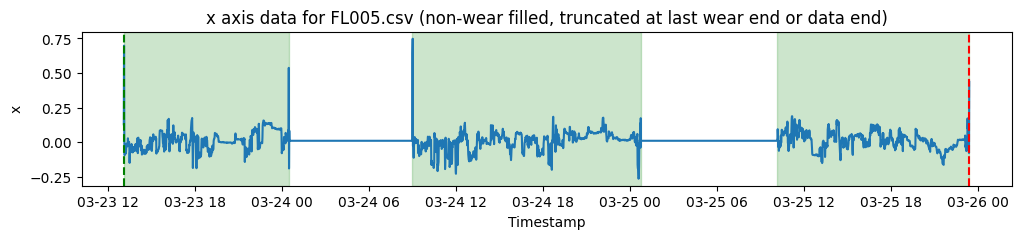

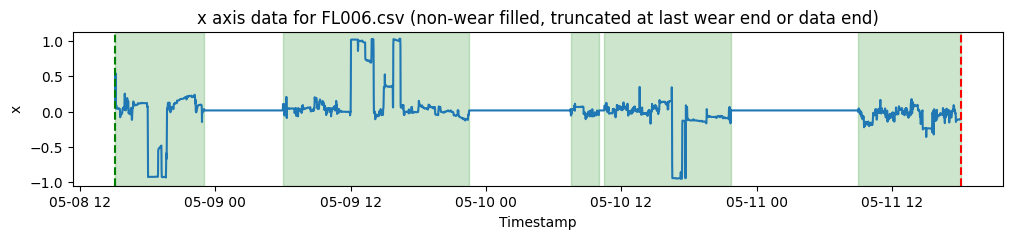

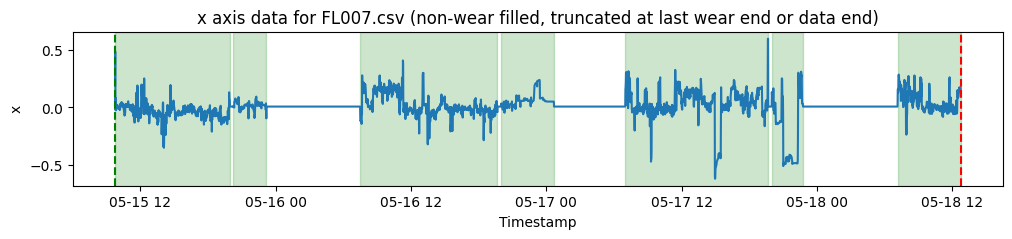

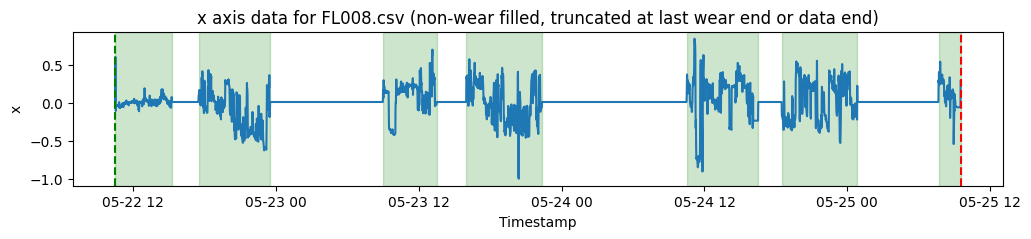

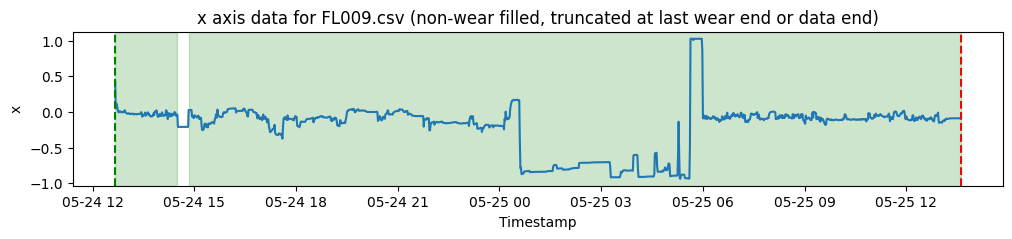

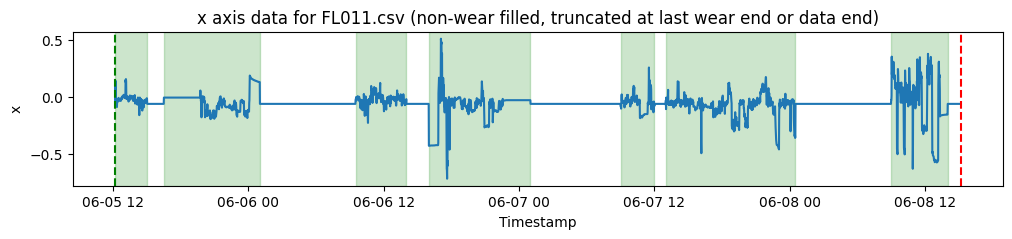

No file found for pig_id FL-013


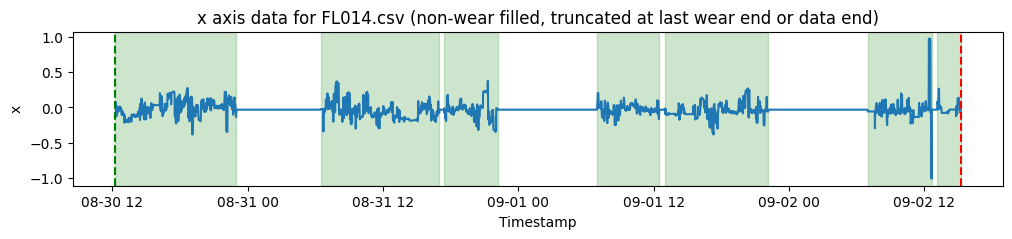

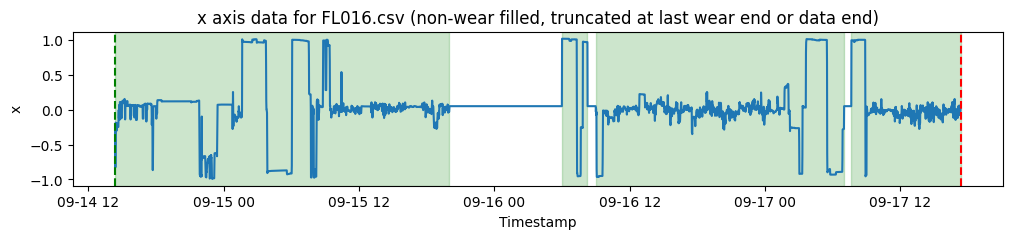

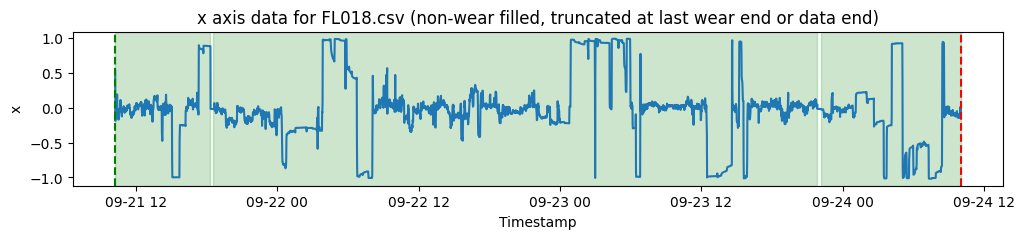

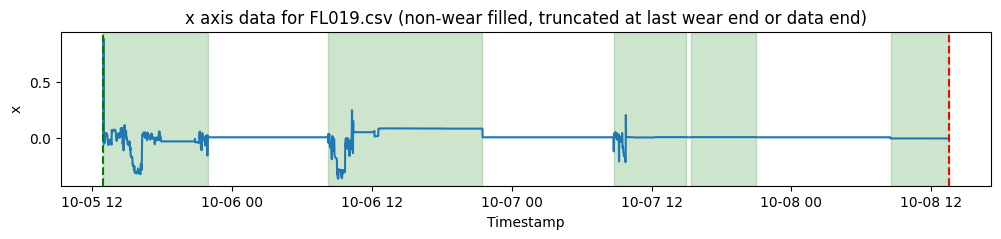

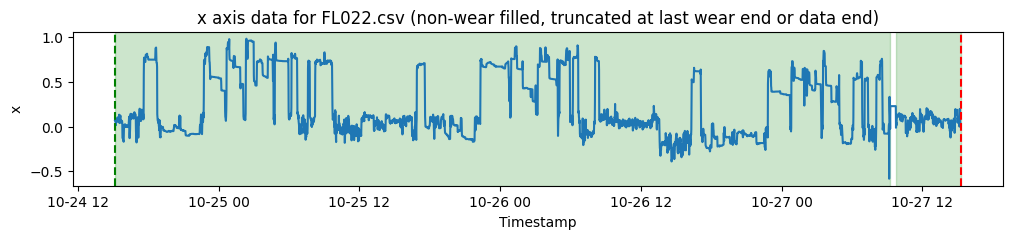

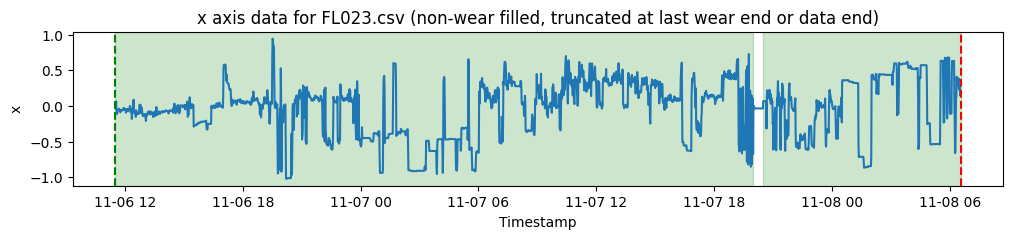

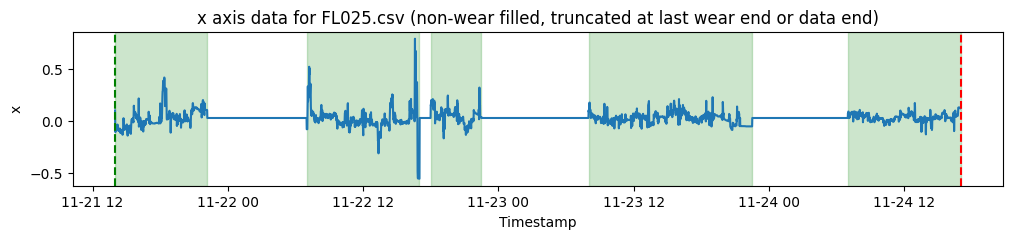

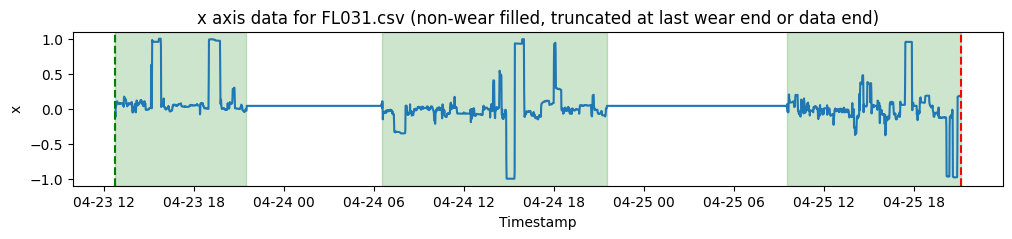

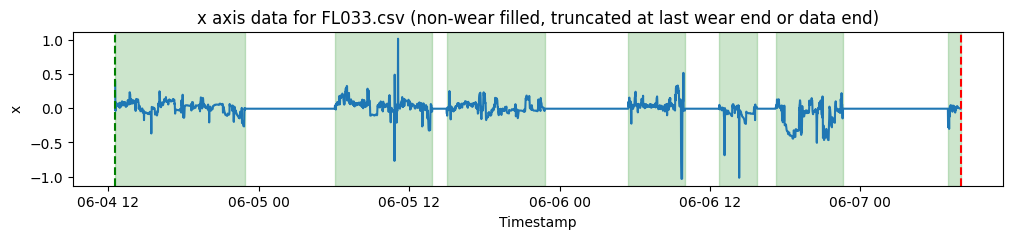

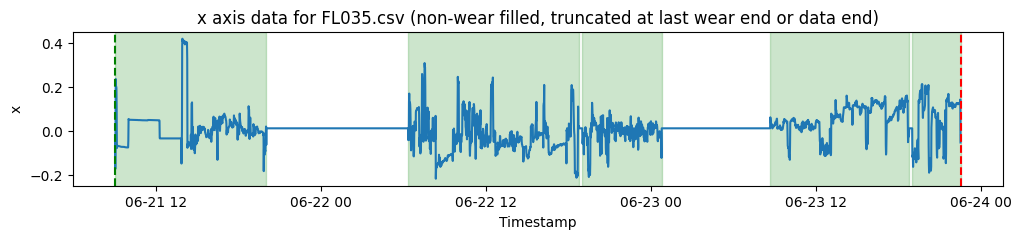

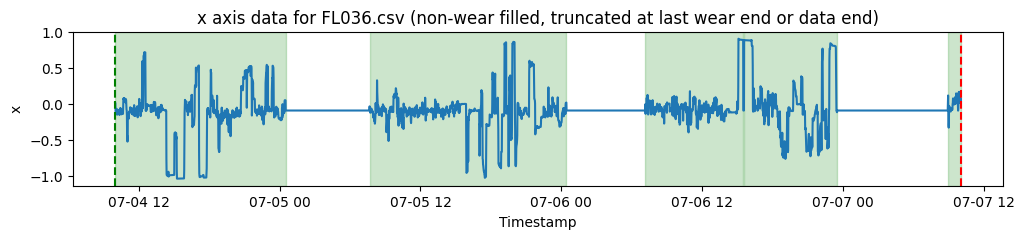

In [39]:
# For each pig_id in wear_df, try to find and plot the corresponding timeseries
for idx, row in wear_df.iterrows():
    pig_id = row['pig_id']
    # Accept both CO-001.csv and CO_001.csv, case-insensitive
    pig_id_pattern = pig_id.replace("-", "[-_]?")
    pattern = re.compile(rf"{pig_id_pattern}\.csv$", re.IGNORECASE)
    matching_files = [f for f in csv_files if pattern.search(os.path.basename(f))]
    if not matching_files:
        print(f"No file found for pig_id {pig_id}")
        continue
    csv_file = matching_files[0]
    df = pd.read_csv(csv_file)
    ts = pd.to_datetime(df['timestamp'])
    file_label = os.path.basename(csv_file)

    # Identify all wear periods and build a mask for wear
    wear_mask = pd.Series(False, index=df.index)
    wear_periods = []
    last_wear_end = None
    for i in range(1, 11):
        start_col = f'wear_start_{i}'
        end_col = f'wear_end_{i}'
        start = row[start_col] if pd.notna(row[start_col]) else ''
        end = row[end_col] if pd.notna(row[end_col]) else ''
        if start and end:
            start_dt = pd.to_datetime(start)
            end_dt = pd.to_datetime(end)
            # Mark as wear period
            mask = (ts >= start_dt) & (ts <= end_dt)
            wear_mask = wear_mask | mask
            wear_periods.append((start_dt, end_dt))
            if last_wear_end is None or end_dt > last_wear_end:
                last_wear_end = end_dt

    # Determine the cutoff for the end of the timeseries
    ts_end = ts.max()
    if last_wear_end is not None:
        cutoff = min(last_wear_end, ts_end)
    else:
        cutoff = ts_end

    # Only consider data up to the cutoff
    valid_mask = ts <= cutoff
    ts_valid = ts[valid_mask]
    df_valid = df.loc[valid_mask].copy()
    wear_mask_valid = wear_mask[valid_mask]

    # Compute the average value of 'x' during wear periods (within valid range)
    if wear_mask_valid.any():
        wear_mean = df_valid.loc[wear_mask_valid, 'x'].mean()
    else:
        wear_mean = df_valid['x'].mean()  # fallback if no wear periods

    # Fill non-wear periods with the average value of wear periods
    df_filled = df_valid.copy()
    df_filled.loc[~wear_mask_valid, 'x'] = wear_mean

    # --- Write the modified, truncated signals to new CSVs ---
    # Ensure output directory exists
    output_dir = "minute_level_modified"
    os.makedirs(output_dir, exist_ok=True)
    # Only keep timestamp, x, y, z columns (if present)
    cols_to_save = [col for col in ['timestamp', 'x', 'y', 'z'] if col in df_filled.columns]
    output_path = os.path.join(output_dir, file_label)
    df_filled[cols_to_save].to_csv(output_path, index=False)

    # --- Plotting (unchanged) ---
    plt.figure(figsize=(12, 2))
    plt.plot(ts_valid, df_filled['x'], label=f"{file_label} x (non-wear filled)")
    plt.axvline(ts_valid.min(), color='g', linestyle='--', label='Min timestamp')
    plt.axvline(ts_valid.max(), color='r', linestyle='--', label='Max timestamp')

    # Plot wear periods as green bands (only those within the cutoff)
    for start_dt, end_dt in wear_periods:
        span_start = max(start_dt, ts_valid.min())
        span_end = min(end_dt, cutoff)
        if span_start < span_end:
            plt.axvspan(span_start, span_end, color='green', alpha=0.2)

    plt.xlabel('Timestamp')
    plt.ylabel('x')
    plt.title(f'x axis data for {file_label} (non-wear filled, truncated at last wear end or data end)')
    plt.show()

In [43]:
modified_dir = "minute_level_modified"
data_handlers = []

preprocess_args = {}  # Define or update this as needed

for fname in os.listdir(modified_dir):
    try:
        file_path = os.path.join(modified_dir, fname)
        if os.path.isfile(file_path):
            handler = csa.datahandlers.GenericDataHandler(
                file_path=file_path,
                data_format='csv',
                data_type='accelerometer-g',
                time_format='datetime',
                time_column='timestamp',
                time_zone="UTC",
                data_columns=['x', 'y', 'z'],
                preprocess_args=preprocess_args,
                verbose=False
            )
            data_handlers.append(handler)
    except Exception as e:
        print(f"Error processing {fname}: {e}")

/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (24.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). N

Noise removal failed, skipping noise removal
__load_data executed in 0.02 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Error processing FL009.csv: Less than 1 day found
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__l

/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). N

Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal failed, skipping noise removal
__load_data executed in 0.01 seconds
Noise removal fa

/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (48.0 hours). No Calibration performed
  warn(
/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/LTMM_Analysis/.venv/lib/python3.10/site-packages/skdh/preprocessing/calibrate.py:163: UserWarning: Less than 72 hours of data (24.0 hours). N

In [ ]:
features_args = {}

bulk_features = csa.features.BulkWearableFeatures(
    handlers=data_handlers, 
    features_args=features_args,
    compute_distributions=True
    )